In [ ]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/Colab Notebooks/project/realwaste-main/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Transformation and loader function
def tranform_loader(name):
  if name == 'densenet121':

    # Define the transformation pipeline (DenseNet121)
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
  elif name == 'inception_v3':

    # Define the transformation pipeline (Inception V3)
    transform_train = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


  class SubsetWithTransform(torch.utils.data.Dataset):
      def __init__(self, subset, transform):
          self.subset = subset
          self.transform = transform
      def __getitem__(self, idx):
          x, y = self.subset[idx]
          return self.transform(x), y
      def __len__(self):
          return len(self.subset)

  # No transform in ImageFolder
  dataset = datasets.ImageFolder(root=data_dir, transform=None)

  # calculate the sizes
  total_size = len(dataset)
  train_size = int(0.8 * total_size)  # 80% train
  test_size = total_size - train_size

  # Split
  db_train, db_test = random_split(dataset, [train_size, test_size])

  # Wrap with transforms
  db_train = SubsetWithTransform(db_train, transform_train)
  db_test = SubsetWithTransform(db_test, transform_test)

  # Define the data loaders
  loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
  loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

  return db_train, db_test, loader_train, loader_test

In [ ]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        if isinstance(pred, tuple):
            pred = pred[0]  # Get only the main output

        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [ ]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [ ]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, db_test, epochs=2, lr=0.001):

  # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Unique class labels from the dataset
    labels_list = list(range(len(dataset.classes)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_normalized = cm / cm.sum(axis=0, keepdims=True)  # Normalize by column (actual label)

    # Confusion matrix heatmap (x = Actual, y = Predicted)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_normalized.T, annot=cm.T, fmt='d', cmap="Blues",
        xticklabels=dataset.classes, yticklabels=dataset.classes,
        cbar_kws={"label": "Percentage of Actual Label"}
    )
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels_list, average=None)
    recall = recall_score(y_true, y_pred, labels=labels_list, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels_list, average=None)

    print(f"\nAccuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        class_name = dataset.classes[i]
        print(f"Class {i} ({class_name}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nMacro-Averaged Metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1 Score:  {macro_f1:.4f}")

In [ ]:
# train-fine-tune-pipeline
def pipeline(model, name):
  model.eval()
  db_train, db_test, loader_train, loader_test = tranform_loader(name)

  # Define the model for 9-class classification
  if name == "densenet121": # DenseNet121
      num_features = model.classifier.in_features
      model.classifier = nn.Linear(num_features, 9)
  elif name == "inception_v3": # InceptionV3
      num_features = model.fc.in_features
      model.fc = nn.Linear(num_features, 9)
  else:
    raise ValueError("Invalid model name")

  # Move entire model to device
  model = model.to(device)

  for name, param in model.named_parameters():
    if 'fc' not in name and 'classifier' not in name:  # Only freeze non-classifier layers
        param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  model.train()
  train(model, loader_train, loader_test, epochs=10, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, db_test, epochs=10, lr=0.001)

  return model, loader_test

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 118/118 [00:48<00:00,  2.46it/s]

Finished epoch 0 of 10: Train Loss = 1.074  Val Loss = 2.331   Train Acc = 0.632   Val Acc = 0.085



100%|██████████| 118/118 [00:48<00:00,  2.42it/s]

Finished epoch 1 of 10: Train Loss = 0.669  Val Loss = 0.679   Train Acc = 0.769   Val Acc = 0.776



100%|██████████| 118/118 [00:47<00:00,  2.50it/s]

Finished epoch 2 of 10: Train Loss = 0.510  Val Loss = 0.664   Train Acc = 0.820   Val Acc = 0.786



100%|██████████| 118/118 [00:47<00:00,  2.51it/s]

Finished epoch 3 of 10: Train Loss = 0.471  Val Loss = 0.540   Train Acc = 0.833   Val Acc = 0.814



100%|██████████| 118/118 [00:47<00:00,  2.48it/s]

Finished epoch 4 of 10: Train Loss = 0.459  Val Loss = 0.583   Train Acc = 0.842   Val Acc = 0.806



100%|██████████| 118/118 [00:48<00:00,  2.43it/s]

Finished epoch 5 of 10: Train Loss = 0.409  Val Loss = 0.594   Train Acc = 0.859   Val Acc = 0.801



100%|██████████| 118/118 [00:47<00:00,  2.48it/s]

Finished epoch 6 of 10: Train Loss = 0.404  Val Loss = 0.660   Train Acc = 0.858   Val Acc = 0.788



100%|██████████| 118/118 [00:46<00:00,  2.51it/s]

Finished epoch 7 of 10: Train Loss = 0.420  Val Loss = 0.782   Train Acc = 0.852   Val Acc = 0.751



100%|██████████| 118/118 [00:46<00:00,  2.52it/s]

Finished epoch 8 of 10: Train Loss = 0.343  Val Loss = 0.578   Train Acc = 0.878   Val Acc = 0.797



100%|██████████| 118/118 [00:46<00:00,  2.52it/s]

Finished epoch 9 of 10: Train Loss = 0.329  Val Loss = 0.608   Train Acc = 0.883   Val Acc = 0.789



100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


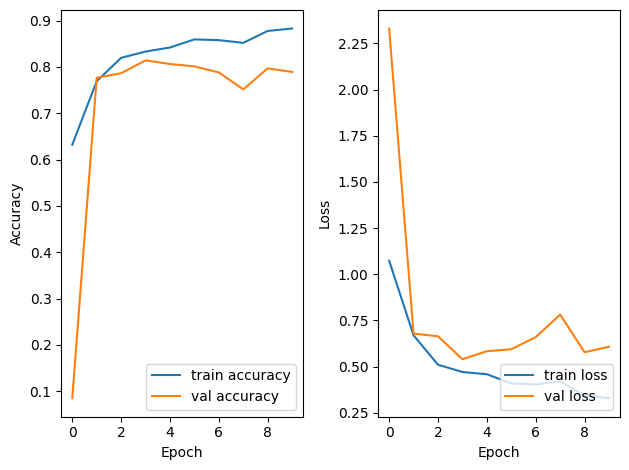

Test accuracy: 82.83%
Test loss: 0.520


100%|██████████| 118/118 [01:10<00:00,  1.67it/s]

Finished epoch 0 of 10: Train Loss = 0.367  Val Loss = 0.520   Train Acc = 0.871   Val Acc = 0.828



100%|██████████| 118/118 [01:10<00:00,  1.67it/s]

Finished epoch 1 of 10: Train Loss = 0.119  Val Loss = 0.457   Train Acc = 0.959   Val Acc = 0.842



100%|██████████| 118/118 [01:10<00:00,  1.67it/s]

Finished epoch 2 of 10: Train Loss = 0.041  Val Loss = 0.343   Train Acc = 0.989   Val Acc = 0.896



100%|██████████| 118/118 [01:11<00:00,  1.64it/s]

Finished epoch 3 of 10: Train Loss = 0.016  Val Loss = 0.337   Train Acc = 0.999   Val Acc = 0.898



100%|██████████| 118/118 [01:11<00:00,  1.66it/s]

Finished epoch 4 of 10: Train Loss = 0.011  Val Loss = 0.316   Train Acc = 0.998   Val Acc = 0.905



100%|██████████| 118/118 [01:11<00:00,  1.65it/s]

Finished epoch 5 of 10: Train Loss = 0.008  Val Loss = 0.308   Train Acc = 0.998   Val Acc = 0.902



100%|██████████| 118/118 [01:11<00:00,  1.65it/s]

Finished epoch 6 of 10: Train Loss = 0.005  Val Loss = 0.314   Train Acc = 1.000   Val Acc = 0.914



100%|██████████| 118/118 [01:11<00:00,  1.66it/s]

Finished epoch 7 of 10: Train Loss = 0.004  Val Loss = 0.299   Train Acc = 1.000   Val Acc = 0.908



100%|██████████| 118/118 [01:11<00:00,  1.65it/s]

Finished epoch 8 of 10: Train Loss = 0.003  Val Loss = 0.293   Train Acc = 1.000   Val Acc = 0.916



100%|██████████| 118/118 [01:11<00:00,  1.65it/s]

Finished epoch 9 of 10: Train Loss = 0.003  Val Loss = 0.302   Train Acc = 0.999   Val Acc = 0.917



100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


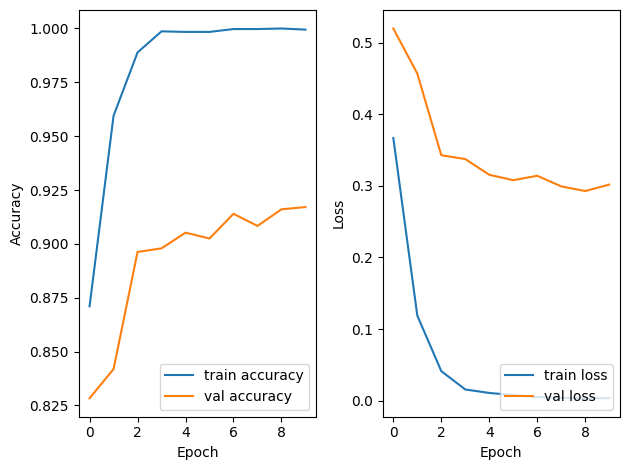

Test accuracy: 91.23%
Test loss: 0.299


In [ ]:
# densenet121
dn, loader_test = pipeline(models.densenet121(pretrained=True), "densenet121")

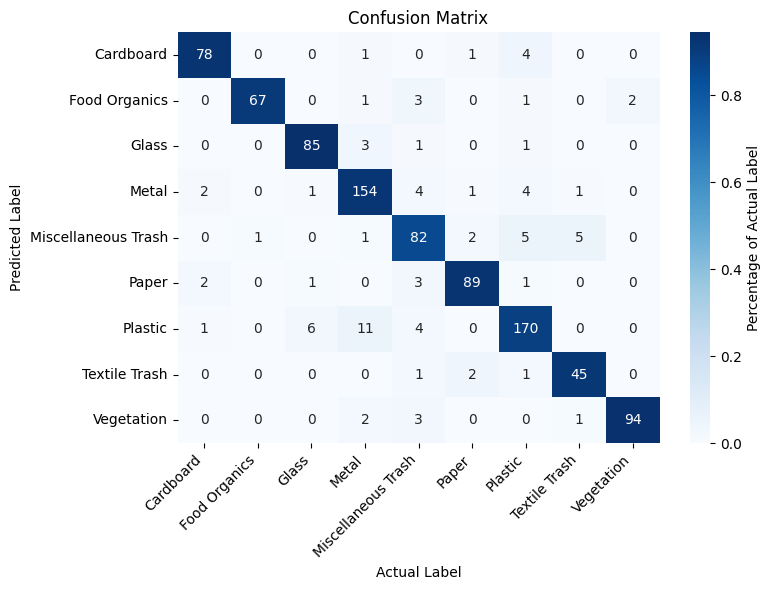


Accuracy: 0.9114
Class 0 (Cardboard): Precision: 0.9286, Recall: 0.9398, F1 Score: 0.9341
Class 1 (Food Organics): Precision: 0.9054, Recall: 0.9853, F1 Score: 0.9437
Class 2 (Glass): Precision: 0.9444, Recall: 0.9140, F1 Score: 0.9290
Class 3 (Metal): Precision: 0.9222, Recall: 0.8902, F1 Score: 0.9059
Class 4 (Miscellaneous Trash): Precision: 0.8542, Recall: 0.8119, F1 Score: 0.8325
Class 5 (Paper): Precision: 0.9271, Recall: 0.9368, F1 Score: 0.9319
Class 6 (Plastic): Precision: 0.8854, Recall: 0.9091, F1 Score: 0.8971
Class 7 (Textile Trash): Precision: 0.9184, Recall: 0.8654, F1 Score: 0.8911
Class 8 (Vegetation): Precision: 0.9400, Recall: 0.9792, F1 Score: 0.9592

Macro-Averaged Metrics:
Precision: 0.9140
Recall:    0.9146
F1 Score:  0.9138


In [ ]:
# evaluate dense121
evaluate_metrics(dn, loader_test)

100%|██████████| 118/118 [00:56<00:00,  2.10it/s]

Finished epoch 0 of 10: Train Loss = 1.357  Val Loss = 2.226   Train Acc = 0.533   Val Acc = 0.106



100%|██████████| 118/118 [00:57<00:00,  2.06it/s]

Finished epoch 1 of 10: Train Loss = 0.932  Val Loss = 0.864   Train Acc = 0.678   Val Acc = 0.715



100%|██████████| 118/118 [00:56<00:00,  2.09it/s]

Finished epoch 2 of 10: Train Loss = 0.845  Val Loss = 0.862   Train Acc = 0.709   Val Acc = 0.692



100%|██████████| 118/118 [00:56<00:00,  2.07it/s]

Finished epoch 3 of 10: Train Loss = 0.846  Val Loss = 0.690   Train Acc = 0.704   Val Acc = 0.761



100%|██████████| 118/118 [00:56<00:00,  2.08it/s]

Finished epoch 4 of 10: Train Loss = 0.797  Val Loss = 0.741   Train Acc = 0.719   Val Acc = 0.739



100%|██████████| 118/118 [00:56<00:00,  2.08it/s]

Finished epoch 5 of 10: Train Loss = 0.768  Val Loss = 0.670   Train Acc = 0.728   Val Acc = 0.775



100%|██████████| 118/118 [00:56<00:00,  2.10it/s]

Finished epoch 6 of 10: Train Loss = 0.791  Val Loss = 0.657   Train Acc = 0.717   Val Acc = 0.781



100%|██████████| 118/118 [00:56<00:00,  2.10it/s]

Finished epoch 7 of 10: Train Loss = 0.767  Val Loss = 0.648   Train Acc = 0.726   Val Acc = 0.776



100%|██████████| 118/118 [00:56<00:00,  2.09it/s]

Finished epoch 8 of 10: Train Loss = 0.785  Val Loss = 0.736   Train Acc = 0.731   Val Acc = 0.751



100%|██████████| 118/118 [00:56<00:00,  2.10it/s]

Finished epoch 9 of 10: Train Loss = 0.740  Val Loss = 0.652   Train Acc = 0.737   Val Acc = 0.793



100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


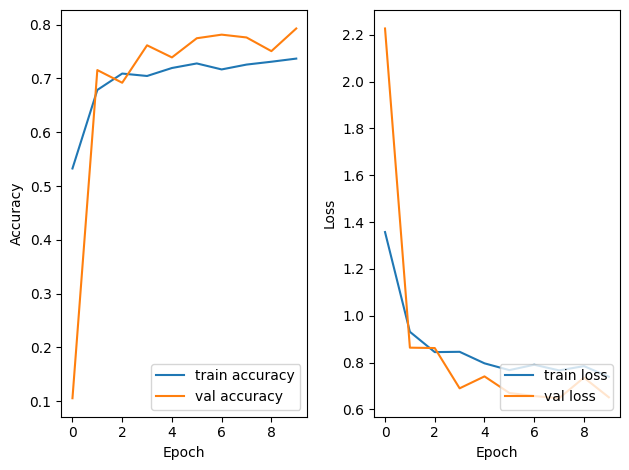

Test accuracy: 79.71%
Test loss: 0.630


100%|██████████| 118/118 [01:31<00:00,  1.29it/s]

Finished epoch 0 of 10: Train Loss = 0.623  Val Loss = 0.630   Train Acc = 0.791   Val Acc = 0.797



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 1 of 10: Train Loss = 0.217  Val Loss = 0.410   Train Acc = 0.930   Val Acc = 0.864



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 2 of 10: Train Loss = 0.087  Val Loss = 0.329   Train Acc = 0.974   Val Acc = 0.902



100%|██████████| 118/118 [01:31<00:00,  1.29it/s]

Finished epoch 3 of 10: Train Loss = 0.059  Val Loss = 0.302   Train Acc = 0.983   Val Acc = 0.910



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 4 of 10: Train Loss = 0.038  Val Loss = 0.298   Train Acc = 0.989   Val Acc = 0.913



100%|██████████| 118/118 [01:31<00:00,  1.30it/s]

Finished epoch 5 of 10: Train Loss = 0.034  Val Loss = 0.304   Train Acc = 0.990   Val Acc = 0.914



100%|██████████| 118/118 [01:31<00:00,  1.29it/s]

Finished epoch 6 of 10: Train Loss = 0.019  Val Loss = 0.315   Train Acc = 0.994   Val Acc = 0.911



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 7 of 10: Train Loss = 0.012  Val Loss = 0.310   Train Acc = 0.997   Val Acc = 0.914



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 8 of 10: Train Loss = 0.012  Val Loss = 0.304   Train Acc = 0.998   Val Acc = 0.912



100%|██████████| 118/118 [01:30<00:00,  1.30it/s]

Finished epoch 9 of 10: Train Loss = 0.011  Val Loss = 0.307   Train Acc = 0.997   Val Acc = 0.919



100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


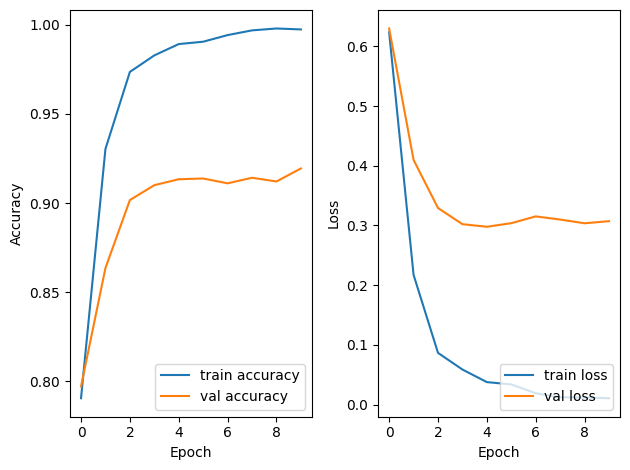

Test accuracy: 91.67%
Test loss: 0.312


In [ ]:
# Inception V3
from torchvision.models import Inception_V3_Weights

inc_v3, loader_test = pipeline(models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1), "inception_v3")

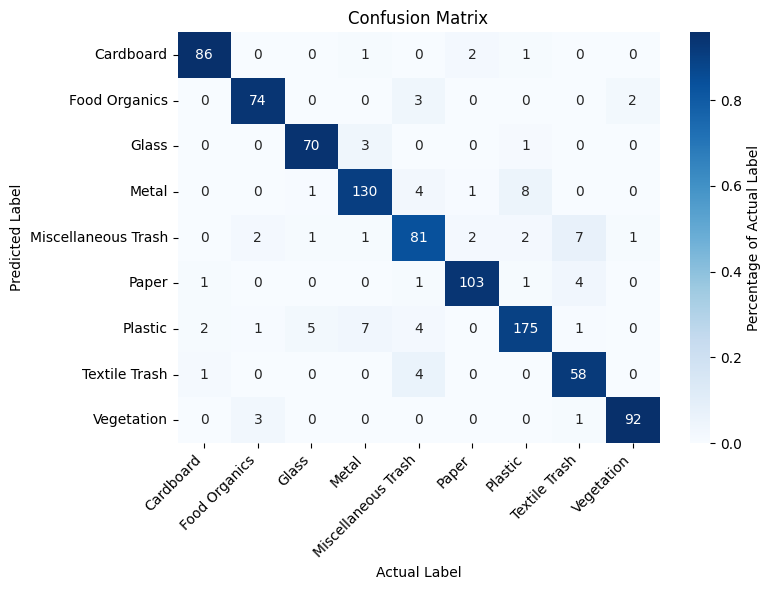


Accuracy: 0.9167
Class 0 (Cardboard): Precision: 0.9556, Recall: 0.9556, F1 Score: 0.9556
Class 1 (Food Organics): Precision: 0.9367, Recall: 0.9250, F1 Score: 0.9308
Class 2 (Glass): Precision: 0.9459, Recall: 0.9091, F1 Score: 0.9272
Class 3 (Metal): Precision: 0.9028, Recall: 0.9155, F1 Score: 0.9091
Class 4 (Miscellaneous Trash): Precision: 0.8351, Recall: 0.8351, F1 Score: 0.8351
Class 5 (Paper): Precision: 0.9364, Recall: 0.9537, F1 Score: 0.9450
Class 6 (Plastic): Precision: 0.8974, Recall: 0.9309, F1 Score: 0.9138
Class 7 (Textile Trash): Precision: 0.9206, Recall: 0.8169, F1 Score: 0.8657
Class 8 (Vegetation): Precision: 0.9583, Recall: 0.9684, F1 Score: 0.9634

Macro-Averaged Metrics:
Precision: 0.9210
Recall:    0.9122
F1 Score:  0.9162


In [ ]:
# evaluate Inception V3
evaluate_metrics(inc_v3, loader_test)